# Collaborators Whereabouts
Author: Sam Eriksen

Description: Notebook to read in collaboration list from google sheets and plot

In [5]:
import os
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import geopy.distance as dist
import airportsdata
from geopy.distance import great_circle
import requests
import matplotlib
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import io
import sys
sys.path.append('../src/sustainable_lz/')
from flights_v2 import flight_emission_calc_v2
flight_co2_100yr=flight_emission_calc_v2(emission_factor=1.7)
flight_co2_30yr=flight_emission_calc_v2(emission_factor=3.)

from author_list_utilities import author_list_util


def cross_calc(data,func,key):
    """
        Defining this here as it requires the two sparate modules
    """
    cumulative_distance=[]
    for index,institute in data.iterrows():
        total_distance=0
        for other_index,other_institute in data.iterrows():
            if index==other_index:
                continue
            total_distance+=other_institute['author_count']*func(dist.distance(
                                         (institute['latitude'],institute['longitude']),
                                         (other_institute['latitude'],other_institute['longitude'])).km)

        cumulative_distance.append(total_distance)

    data[key]=cumulative_distance

def plot_sites(institution_dist,key='cumulative_CO2e_30yr',normalisation=1):
    """
        institution_dist : data frame of instiutions
        nomralisation : something to scale the CO2e or distance by
        key : what to put on the colorbar
    """

    longs=np.array(institution_dist.sort_values(by=[key])['longitude'])
    lats=np.array(institution_dist.sort_values(by=[key])['latitude'])


    world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    carbon_map = matplotlib.colormaps['summer']
    world.boundary.plot(ax=ax, zorder=1) 
    max_marker=150
    min_marker=50

    for i,(long,lat) in enumerate(np.transpose([longs,lats])):
        color=carbon_map(i/len(longs))
        ax.scatter(long,lat, marker='*', color=color,s=100)

    cmap = carbon_map
    min_dist=max(institution_dist[key])*normalisation
    max_dist=min(institution_dist[key])*normalisation
    norm = matplotlib.colors.Normalize(vmin=min_dist, vmax=max_dist)

    clb=plt.colorbar(matplotlib.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
                 label='tCO2e of flights',ticks=np.linspace(min_dist,max_dist,5,endpoint=True),
                format='%.1f')
    clb.set_label('tCO2e for every Author',fontsize=18)
    plt.xlim([-140,155])
    plt.ylim([-40,60])
    plt.xlabel("longitude ($^\circ$)",fontsize=18)
    plt.ylabel("latitude ($^\circ$)",fontsize=18)
    clb.ax.tick_params(labelsize='large')
    return clb

# Initliase the author list

In [6]:
pickle_file = 'author_list_obj.pkl'

if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        attendees = pickle.load(f)
    print("Pickle file loaded.")
else:
    attendees=pd.read_csv('../data/LZ_Brown_collab_24_attendence.csv')
    attendees['FirstName']=attendees['First Name']
    attendees['LastName']=attendees['Last name']
    author_list=author_list_util(attendance_list_df=attendees)
    with open(pickle_file, 'wb') as f:
        pickle.dump(author_list, f)
    print("Pickle file created and saved.")



/home/frodo/downlaoded_sus_lz/sustainable_lz/brown_transport/git_sus_lz/notebooks/../src/sustainable_lz/author_list_utilities.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.authorship_list['Attended']=True


Attendence was 18.0%
Finding Instituition locations
Daejeon, KOR
Correcting funky beahvoiur for Maryland
Pickle file created and saved.


/home/frodo/downlaoded_sus_lz/sustainable_lz/brown_transport/git_sus_lz/notebooks/../src/sustainable_lz/author_list_utilities.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.author_university_locations["author_count"] = self.institutions['University'].map(author_counts)


# fix some magic stuff

For somereason University of Marydland thinks it's in Stadelheim, Obergiesi

In [7]:
author_list.author_university_locations[author_list.author_university_locations['University']=='University of Maryland']['latitude'],author_list.author_university_locations[author_list.author_university_locations['University']=='University of Maryland']['longitude']

(34    38.985829
 Name: latitude, dtype: float64,
 34   -76.93733
 Name: longitude, dtype: float64)

Get university address information

Plot on a map all universities involved

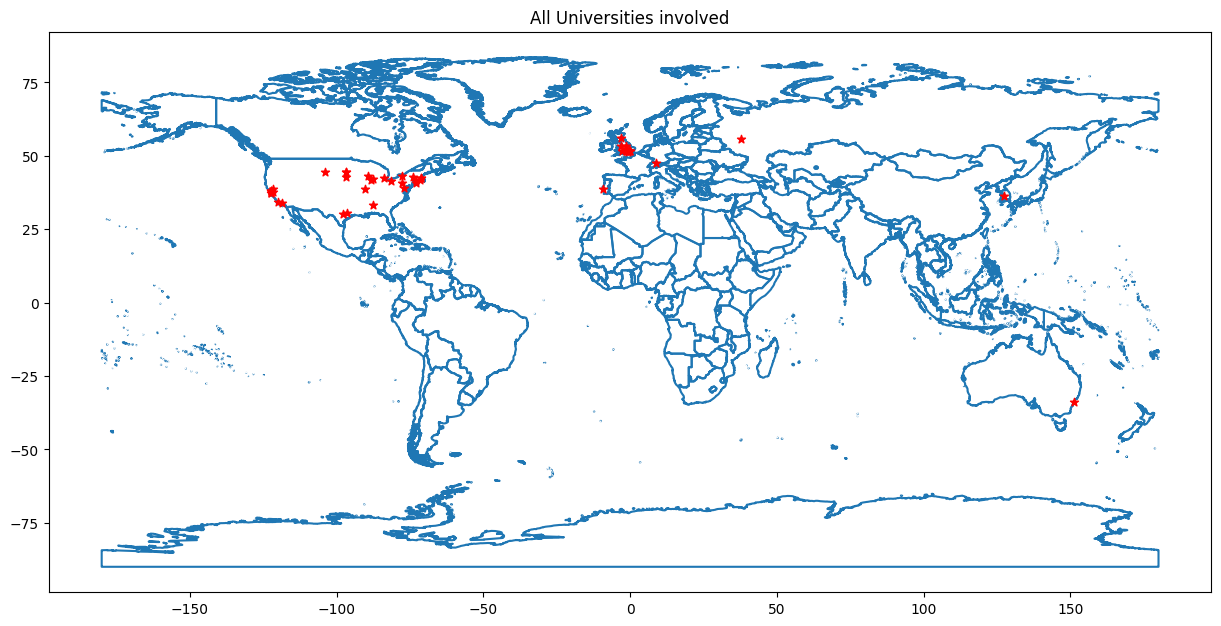

In [8]:
world = gpd.read_file('../data/maps/ne_10m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(author_list.institutions['longitude'],author_list.institutions['latitude'], marker='*', color='red', zorder=2)

ax.set_title('All Universities involved')
plt.show()

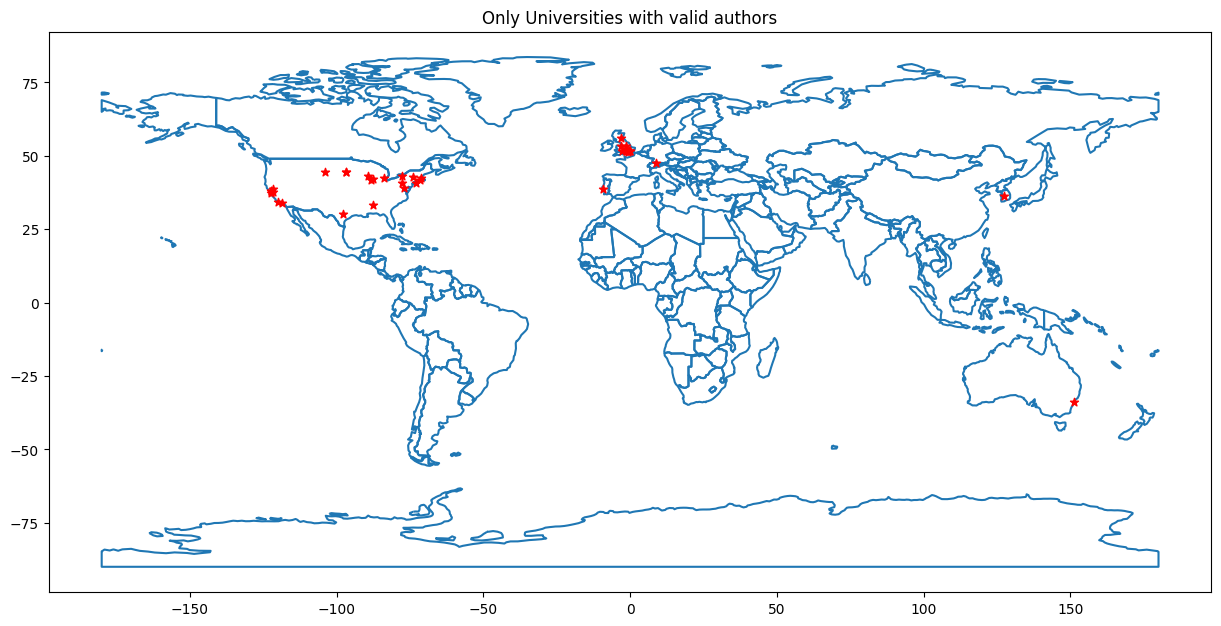

In [9]:
world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

 
author_list.filter_to_authors()

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(author_list.institutions['longitude'],author_list.institutions['latitude'], marker='*', color='red', zorder=2)


grouped_by_country_or_state=author_list.group_by_country_or_state()
author_list.remove_filters()
# author_list.remove_filter_to_authors()
ax.set_title('Only Universities with valid authors')
plt.show()

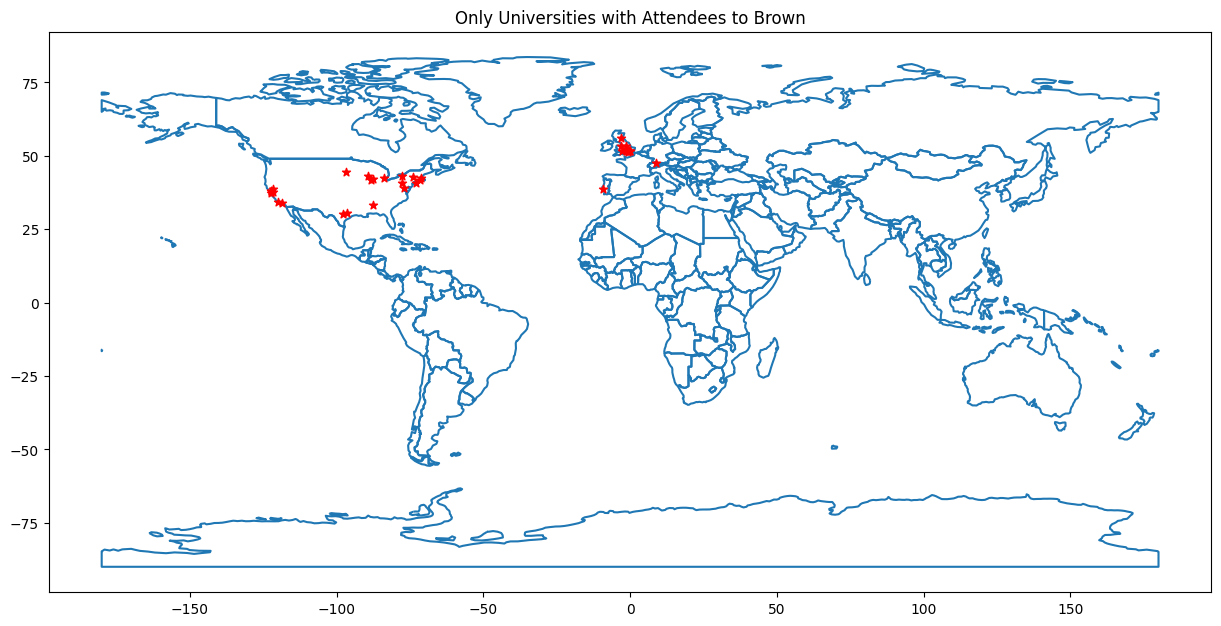

In [10]:
world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

 
author_list.filter_to_attendees()

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(author_list.institutions['longitude'],author_list.institutions['latitude'], marker='*', color='red', zorder=2)


grouped_by_country_or_state=author_list.group_by_country_or_state()
# author_list.remove_filters()
# author_list.remove_filter_to_authors()
ax.set_title('Only Universities with Attendees to Brown')
plt.show()

# Code to calculate CO2 to every other location, could probably wrap up a bit nicer

# Calculate assuming all attendees 
We only expected 74 of the 100 to fly due to virtual or being close, may need to cut on data frame to remove local as they would not fly

Filtered counts:  100
The data frames are not scaled, you must use the above to scale them
Lowest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
24,University at Albany (SUNY),"Department of Physics, 1400 Washington Avenue,...","University at Albany (SUNY), Department of Phy...","NY 12222-1000, USA",University at Albany,"Department of Physics, 1400 Washington Avenue","(University at Albany, The State University of...",-73.825877,42.684027,6,67.253895,112.326032
38,University of Rochester,"Department of Physics and Astronomy, Rochester...","University of Rochester, Department of Physics...","NY 14627-0171, USA",University of Rochester,"Department of Physics and Astronomy, Rochester","(University of Rochester River Campus, Gold St...",-77.628784,43.129864,1,67.379285,112.459172
17,Pennsylvania State University,"Department of Physics, 104 Davey Lab, Universi...","Pennsylvania State University, Department of P...","PA 16802-6300, USA",Pennsylvania State University,"Department of Physics, 104 Davey Lab","(Penn State University, Cottonwood Avenue, Col...",-77.855938,40.802583,5,67.712332,113.087513


Greatest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
47,King's College London,"Department of Physics, King's College London, ...","King's College London, Department of Physics, ...","WC2R 2LS, United Kingdom",King's College London,"Department of Physics, King's College London","(Hodgkin Building, Tennis Street, Bermondsey V...",-0.090002,51.503085,1,116.957182,196.399477
12,Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra, ...",Laboratório de Instrumentação e Física Experim...,"Coimbra, Portugal",Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra",(LIP - Laboratório de Instrumentação e Física ...,-9.143368,38.739920,1,127.805440,214.764701
50,University of Zurich,"Department of Physics, University of Zurich, W...","University of Zurich, Department of Physics, U...","8057 Zurich, Switzerland",University of Zurich,"Department of Physics, University of Zurich",(Zürcher Hochschule für Angewandte Wissenschaf...,8.729807,47.496843,3,135.045780,227.060285


For LA


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
30,"University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles...","University of California, Los Angeles, Departm...","CA 90095-1547, USA","University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles","(University of California, Los Angeles, Medica...",-118.44685,34.070878,3,94.67464,158.708639


For Brown


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
7,Brown University,"Department of Physics, 182 Hope Street, Provid...","Brown University, Department of Physics, 182 H...","RI 02912-9037, USA",Brown University,"Department of Physics, 182 Hope Street","(Brown University, South Main Street, Fox Poin...",-71.408801,41.81864,5,68.77377,114.882539


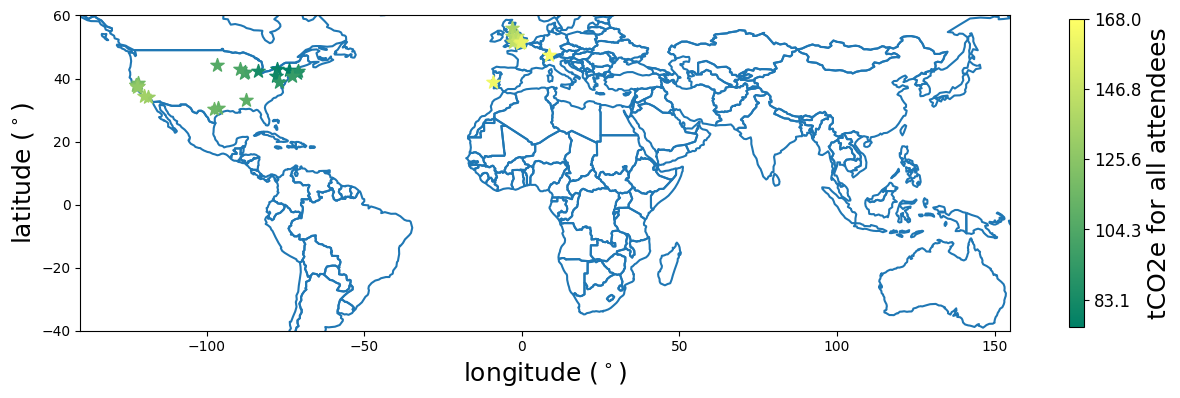

In [11]:
author_list.remove_filters()
author_list.filter_to_attendees()
#filtering rn reclaulates the author_university_locations dataframe 
cross_calc(author_list.author_university_locations,flight_co2_100yr.calc_emissions_v2,'cumulative_CO2e_100yr')
cross_calc(author_list.author_university_locations,flight_co2_30yr.calc_emissions_v2,'cumulative_CO2e_30yr')
clb=plot_sites(author_list.author_university_locations,normalisation=74/100)
clb.set_label('tCO2e for all attendees',fontsize=18)
print("Filtered counts: ",np.sum(author_list.author_university_locations['author_count']))
print("The data frames are not scaled, you must use the above to scale them")
print("Lowest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[:3],)
print("Greatest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[-3:])
print("For LA")
display(author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'University of California, Los Angeles'])
print("For Brown")
author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'Brown University']

So Brown gives 115(69)for all attendees but we can scale that down by 74/100 to 85(51)tCO2e/yr

# calculate assuming average fliers from the authorship list
The scaling here would be the fliers (74) divided by the number of authors

Filtered counts:  224
The data frames are not scaled, you must use the above to scale them
Lowest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
38,University of Rochester,"Department of Physics and Astronomy, Rochester...","University of Rochester, Department of Physics...","NY 14627-0171, USA",University of Rochester,"Department of Physics and Astronomy, Rochester","(University of Rochester River Campus, Gold St...",-77.628784,43.129864,6,170.757888,285.537072
24,University at Albany (SUNY),"Department of Physics, 1400 Washington Avenue,...","University at Albany (SUNY), Department of Phy...","NY 12222-1000, USA",University at Albany,"Department of Physics, 1400 Washington Avenue","(University at Albany, The State University of...",-73.825877,42.684027,6,171.863594,287.406445
36,University of Michigan,"Randall Laboratory of Physics, 450 Church Stre...","University of Michigan, Randall Laboratory of ...","MI 48109-1040, USA",University of Michigan,"Randall Laboratory of Physics, 450 Church Street","(University of Michigan, 500, South State Stre...",-83.710039,42.294214,12,172.564451,288.695131


Greatest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
50,University of Zurich,"Department of Physics, University of Zurich, W...","University of Zurich, Department of Physics, U...","8057 Zurich, Switzerland",University of Zurich,"Department of Physics, University of Zurich",(Zürcher Hochschule für Angewandte Wissenschaf...,8.729807,47.496843,5,287.665061,483.473238
8,Center for Underground Physics (CUP),"IBS Center for Underground Physics 70, Yuseong...","Center for Underground Physics (CUP), IBS Cent...","Daejeon, KOR",Center for Underground Physics,"IBS Center for Underground Physics 70, Yuseong...",None,127.384520,36.375394,2,524.340663,884.164793
48,University of Sydney,"School of Physics, Physics Road, The Universit...","University of Sydney, School of Physics, Physi...","NSW 2006, Australia",University of Sydney,"School of Physics, Physics Road","(The University of Sydney, University Avenue, ...",151.189411,-33.888907,1,973.894576,1645.631813


For LA


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
30,"University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles...","University of California, Los Angeles, Departm...","CA 90095-1547, USA","University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles","(University of California, Los Angeles, Medica...",-118.44685,34.070878,3,238.500541,400.196807


For Brown


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
7,Brown University,"Department of Physics, 182 Hope Street, Provid...","Brown University, Department of Physics, 182 H...","RI 02912-9037, USA",Brown University,"Department of Physics, 182 Hope Street","(Brown University, South Main Street, Fox Poin...",-71.408801,41.81864,9,173.926649,290.945518


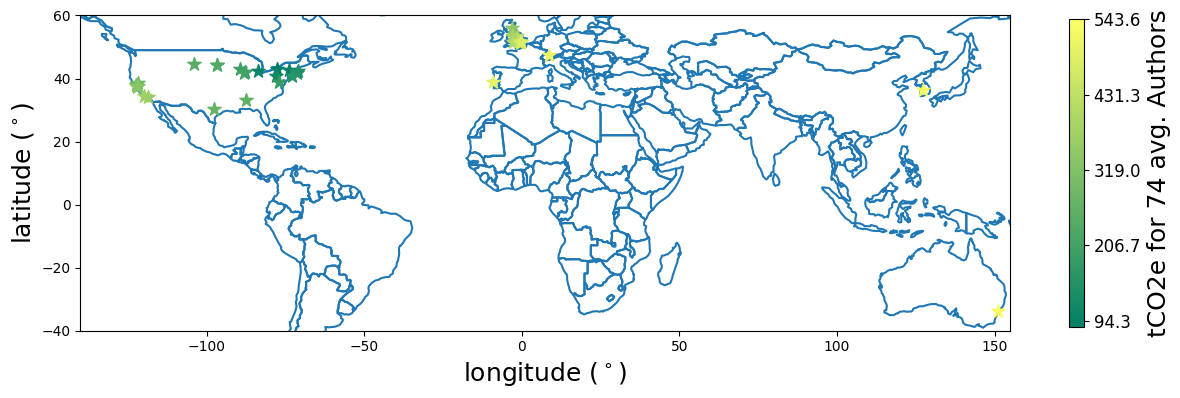

In [12]:
author_list.remove_filters()
author_list.filter_to_authors()
#filtering rn reclaulates the author_university_locations dataframe 
cross_calc(author_list.author_university_locations,flight_co2_100yr.calc_emissions_v2,'cumulative_CO2e_100yr')
cross_calc(author_list.author_university_locations,flight_co2_30yr.calc_emissions_v2,'cumulative_CO2e_30yr')
clb=plot_sites(author_list.author_university_locations,normalisation=74/np.sum(author_list.author_university_locations['author_count']))
clb.set_label('tCO2e for 74 avg. Authors',fontsize=18)
print("Filtered counts: ",np.sum(author_list.author_university_locations['author_count']))
print("The data frames are not scaled, you must use the above to scale them")
print("Lowest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[:3],)
print("Greatest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[-3:])
print("For LA")
display(author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'University of California, Los Angeles'])
print("For Brown")
author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'Brown University']

74 average authors (scale numbers by 74/224) flying to brown yields 96(57)

# what about just everyone on the list

Filtered counts:  557.0
Lowest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
38,University of Rochester,"Department of Physics and Astronomy, Rochester...","University of Rochester, Department of Physics...","NY 14627-0171, USA",University of Rochester,"Department of Physics and Astronomy, Rochester","(University of Rochester River Campus, Fireman...",-77.628784,43.129864,11.0,428.084610,715.853106
36,University of Michigan,"Randall Laboratory of Physics, 450 Church Stre...","University of Michigan, Randall Laboratory of ...","MI 48109-1040, USA",University of Michigan,"Randall Laboratory of Physics, 450 Church Street","(University of Michigan, 500, South State Stre...",-83.710039,42.294214,19.0,428.840977,717.270967
41,University of Wisconsin-Madison,"Department of Physics, 1150 University Avenue ...","University of Wisconsin-Madison, Department of...","WI 53706-1390, USA",University of Wisconsin-Madison,"Department of Physics, 1150 University Avenue ...","(University of Wisconsin-Madison, Purdue Stree...",-89.430959,43.080274,17.0,431.891612,722.410415


Greatest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
15,National Research Nuclear University MEPhI (NR...,"31 Kashirskoe shosse, Moscow, 115409, RUS",National Research Nuclear University MEPhI (NR...,"115409, RUS",National Research Nuclear University MEPhI,"31 Kashirskoe shosse, Moscow",(Национальный исследовательский ядерный универ...,37.665800,55.650451,6.0,842.921408,1418.120517
8,Center for Underground Physics (CUP),"IBS Center for Underground Physics 70, Yuseong...","Center for Underground Physics (CUP), IBS Cent...","Daejeon, KOR",Center for Underground Physics,"IBS Center for Underground Physics 70, Yuseong...",None,127.384520,36.375394,6.0,1299.473828,2191.212548
48,University of Sydney,"School of Physics, Physics Road, The Universit...","University of Sydney, School of Physics, Physi...","NSW 2006, Australia",University of Sydney,"School of Physics, Physics Road","(The University of Sydney, Egan Street, Newtow...",151.189411,-33.888907,4.0,2382.462010,4025.609529


For LA
For Brown


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
7,Brown University,"Department of Physics, 182 Hope Street, Provid...","Brown University, Department of Physics, 182 H...","RI 02912-9037, USA",Brown University,"Department of Physics, 182 Hope Street","(Brown University, Amy Street, Fox Point, Prov...",-71.408801,41.81864,31.0,435.29622,728.370966


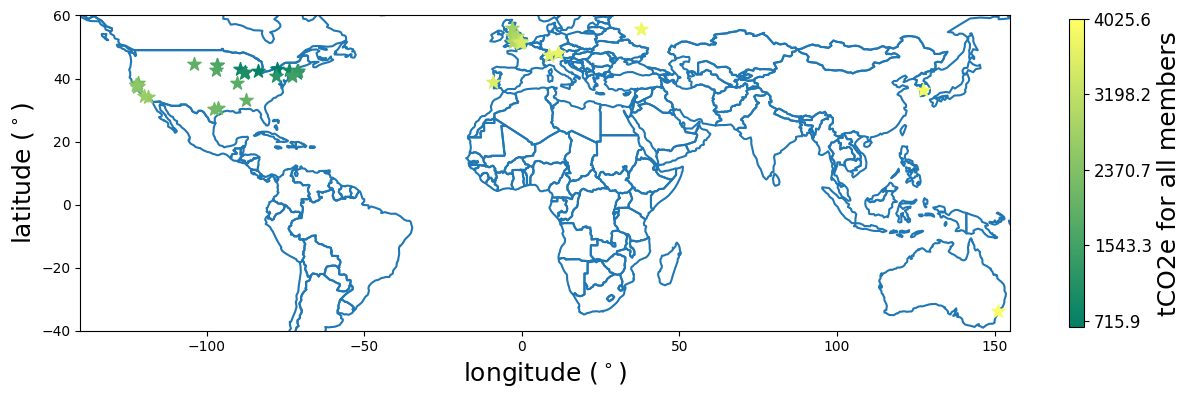

In [24]:
author_list.remove_filters()

#filtering rn reclaulates the author_university_locations dataframe 
cross_calc(author_list.author_university_locations,flight_co2_100yr.calc_emissions_v2,'cumulative_CO2e_100yr')
cross_calc(author_list.author_university_locations,flight_co2_30yr.calc_emissions_v2,'cumulative_CO2e_30yr')
clb=plot_sites(author_list.author_university_locations,normalisation=1)
clb.set_label('tCO2e for all members',fontsize=18)
print("Filtered counts: ",np.sum(author_list.author_university_locations['author_count']))
print("The data frames are not scaled, you must use the above to scale them")
print("Lowest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[:3],)
print("Greatest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[-3:])
print("For LA")
display(author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'University of California, Los Angeles'])
print("For Brown")
author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'Brown University']

74 average members (scale numbers by 74/557) flying to brown yields 97(57)

# what about all authors?

Lowest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
38,University of Rochester,"Department of Physics and Astronomy, Rochester...","University of Rochester, Department of Physics...","NY 14627-0171, USA",University of Rochester,"Department of Physics and Astronomy, Rochester","(University of Rochester River Campus, Fireman...",-77.628784,43.129864,6,180.318787,301.720578
24,University at Albany (SUNY),"Department of Physics, 1400 Washington Avenue,...","University at Albany (SUNY), Department of Phy...","NY 12222-1000, USA",University at Albany,"Department of Physics, 1400 Washington Avenue","(University at Albany, The State University of...",-73.825877,42.684027,6,180.948113,302.783339
7,Brown University,"Department of Physics, 182 Hope Street, Provid...","Brown University, Department of Physics, 182 H...","RI 02912-9037, USA",Brown University,"Department of Physics, 182 Hope Street","(Brown University, Amy Street, Fox Point, Prov...",-71.408801,41.818640,9,182.686146,305.772142


Greatest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
34,University of Maryland,"Department of Physics, College Park, MD 20742-...","University of Maryland, Department of Physics,...","MD 20742-4111, USA",University of Maryland,"Department of Physics, College Park","(University of Maryland, Stadelheim, Obergiesi...",11.582349,48.098982,8,282.966553,475.570530
8,Center for Underground Physics (CUP),"IBS Center for Underground Physics 70, Yuseong...","Center for Underground Physics (CUP), IBS Cent...","Daejeon, KOR",Center for Underground Physics,"IBS Center for Underground Physics 70, Yuseong...",None,127.384520,36.375394,2,517.491332,872.564363
48,University of Sydney,"School of Physics, Physics Road, The Universit...","University of Sydney, School of Physics, Physi...","NSW 2006, Australia",University of Sydney,"School of Physics, Physics Road","(The University of Sydney, Egan Street, Newtow...",151.189411,-33.888907,1,976.081180,1649.336029


For LA


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
30,"University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles...","University of California, Los Angeles, Departm...","CA 90095-1547, USA","University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles","(University of California, Los Angeles, Portol...",-118.44685,34.070878,3,250.887839,421.172063


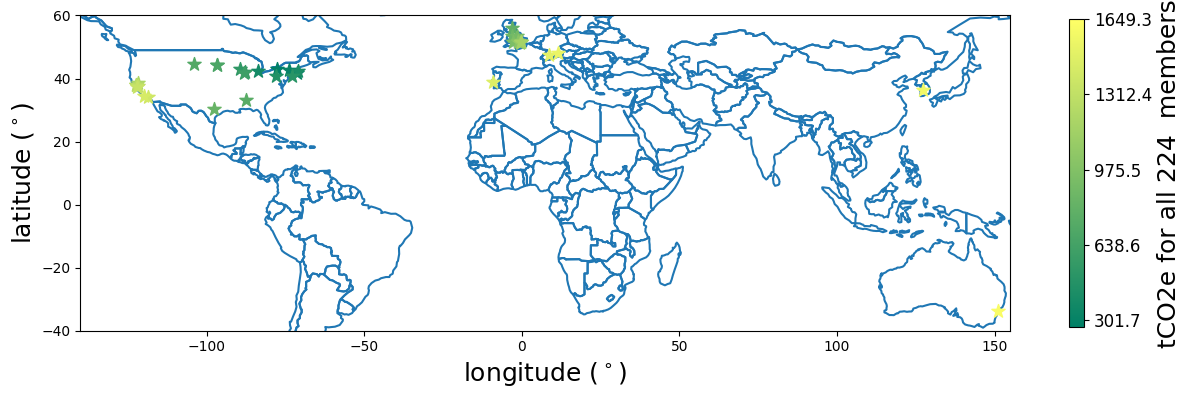

In [17]:
author_list.remove_filters()
author_list.filter_to_authors()
#filtering rn reclaulates the author_university_locations dataframe 
cross_calc(author_list.author_university_locations,flight_co2_100yr.calc_emissions_v2,'cumulative_CO2e_100yr')
cross_calc(author_list.author_university_locations,flight_co2_30yr.calc_emissions_v2,'cumulative_CO2e_30yr')
clb=plot_sites(author_list.author_university_locations,normalisation=1)
clb.set_label('tCO2e for all %i  members'%np.sum(author_list.author_university_locations['author_count']),fontsize=18)
print("Lowest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[:3],)
print("Greatest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[-3:])
print("For LA")
author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'University of California, Los Angeles']

This would yield 80(45) tCO2e for the Brown respondents (different code) so approximately 138 (78) tCO2e after correction. 

Just assuming 74 `average' authors from the author list yields 100 (60) tCO2e, removing the authorship requirement gives 97 (58)tCO2e.

This suggests that either most attendees who flew did respond or that the authorship list consistently underestimates the total length of flights. 

We cannot know until we gather further data from future meetings. In order to not over-report any impact of reducing flights we will assume 74 fliers but that the authorship list is representative of average attendees .

# Given attendees and respondents aligns well with authors, use authors for a average locations

Exclude Those outside US and UK - unlikely to occur

In [37]:
sites_to_plot.sort_values(by=['cumulative_CO2e_100yr']).iloc[-2]['University']

'Laboratório de Instrumentação e Física Experimental de Partículas (LIP)'

Filtered counts:  224
The data frames are not scaled, you must use the above to scale them
Lowest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
38,University of Rochester,"Department of Physics and Astronomy, Rochester...","University of Rochester, Department of Physics...","NY 14627-0171, USA",University of Rochester,"Department of Physics and Astronomy, Rochester","(University of Rochester River Campus, Gold St...",-77.628784,43.129864,6,170.757888,285.537072
24,University at Albany (SUNY),"Department of Physics, 1400 Washington Avenue,...","University at Albany (SUNY), Department of Phy...","NY 12222-1000, USA",University at Albany,"Department of Physics, 1400 Washington Avenue","(University at Albany, The State University of...",-73.825877,42.684027,6,171.863594,287.406445
36,University of Michigan,"Randall Laboratory of Physics, 450 Church Stre...","University of Michigan, Randall Laboratory of ...","MI 48109-1040, USA",University of Michigan,"Randall Laboratory of Physics, 450 Church Street","(University of Michigan, 500, South State Stre...",-83.710039,42.294214,12,172.564451,288.695131


Greatest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
18,"Royal Holloway, University of London","Department of Physics, Egham, TW20 0EX, UK","Royal Holloway, University of London, Departme...","TW20 0EX, UK","Royal Holloway, University of London","Department of Physics, Egham","(Royal Holloway, London Road, Englefield Green...",-0.564256,51.424450,5,247.566465,415.577727
10,Imperial College London,"Physics Department, Blackett Laboratory, Londo...","Imperial College London, Physics Department, B...","London SW7 2AZ, UK",Imperial College London,"Physics Department, Blackett Laboratory","(Imperial College London, Exhibition Road, Bro...",-0.175641,51.498959,9,247.699111,415.866496
47,King's College London,"Department of Physics, King's College London, ...","King's College London, Department of Physics, ...","WC2R 2LS, United Kingdom",King's College London,"Department of Physics, King's College London","(Hodgkin Building, Tennis Street, Bermondsey V...",-0.090002,51.503085,3,248.692604,417.452446


For LA


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
30,"University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles...","University of California, Los Angeles, Departm...","CA 90095-1547, USA","University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles","(University of California, Los Angeles, Medica...",-118.44685,34.070878,3,238.500541,400.196807


For Brown


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
7,Brown University,"Department of Physics, 182 Hope Street, Provid...","Brown University, Department of Physics, 182 H...","RI 02912-9037, USA",Brown University,"Department of Physics, 182 Hope Street","(Brown University, South Main Street, Fox Poin...",-71.408801,41.81864,9,173.926649,290.945518


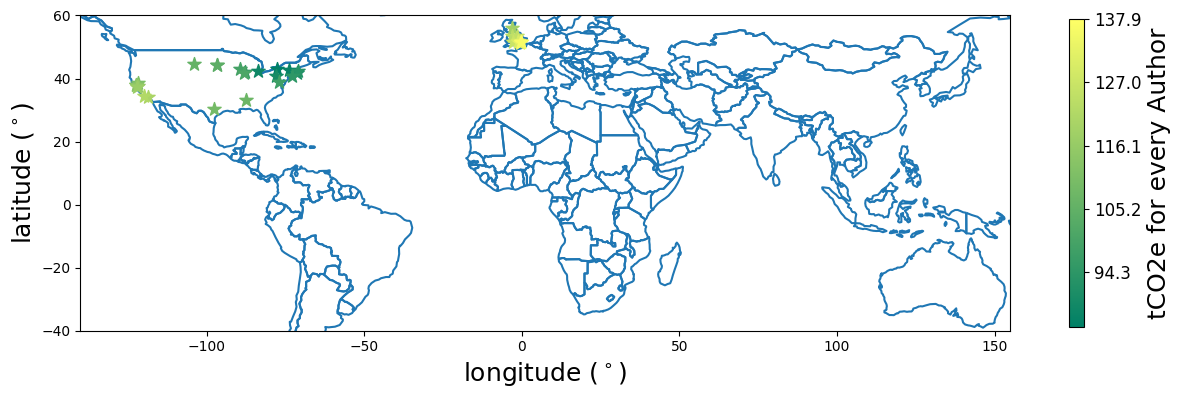

In [23]:
from copy import deepcopy
author_list.remove_filters()
author_list.filter_to_authors()
#filtering rn reclaulates the author_university_locations dataframe 
cross_calc(author_list.author_university_locations,flight_co2_100yr.calc_emissions_v2,'cumulative_CO2e_100yr')
cross_calc(author_list.author_university_locations,flight_co2_30yr.calc_emissions_v2,'cumulative_CO2e_30yr')

#lets remove Sydney, Melbourne, Zurich, and 
remove=['University of Zurich','Center for Underground Physics (CUP)','University of Sydney','Laboratório de Instrumentação e Física Experimental de Partículas (LIP)']
sites_to_plot=deepcopy(author_list.author_university_locations)
for remove_site in remove:
    sites_to_plot=sites_to_plot[sites_to_plot['University']!=remove_site]
clb=plot_sites(sites_to_plot,normalisation=74/np.sum(author_list.author_university_locations['author_count']))


# clb.set_label('tCO2e for 74 avg. Authors',fontsize=18)
print("Filtered counts: ",np.sum(author_list.author_university_locations['author_count']))
print("The data frames are not scaled, you must use the above to scale them")
print("Lowest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[:3],)
print("Greatest Three given attendees")
display(sites_to_plot.sort_values(by=['cumulative_CO2e_100yr']).iloc[-3:])
print("For LA")
display(author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'University of California, Los Angeles'])
print("For Brown")
author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'Brown University']

In [30]:
cut=(sites_to_plot['longitude']<-10) & (sites_to_plot['longitude']>-110)
scale=74/224
scale*np.median(sites_to_plot['cumulative_CO2e_100yr'][cut]) ,scale*np.median(sites_to_plot['cumulative_CO2e_30yr'][cut]) 

(58.63034215835767, 98.08200817644769)

In [31]:
scale*np.median(sites_to_plot['cumulative_CO2e_100yr'][sites_to_plot['longitude']>-10]) ,scale*np.median(sites_to_plot['cumulative_CO2e_30yr'][sites_to_plot['longitude']>-10]) 

(81.01171516273503, 135.98964922111404)

In [32]:
scale*np.median(sites_to_plot['cumulative_CO2e_100yr'][sites_to_plot['longitude']<-110]) ,scale*np.median(sites_to_plot['cumulative_CO2e_30yr'][sites_to_plot['longitude']<-110]) 

(76.69331547815203, 128.66220542031493)

In [33]:
scale*np.median(sites_to_plot['cumulative_CO2e_100yr']),scale*np.median(sites_to_plot['cumulative_CO2e_30yr'])

(76.2213232597741, 127.85752276021593)

In [18]:
sites_to_plot[cut].sort_values(by=['cumulative_CO2e_100yr'])

,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
49,University of Texas at Austin,"Department of Physics, 2515 Speedway, C1600\nA...","University of Texas at Austin, Department of P...","TX 78712-1192, USA",University of Texas at Austin,"Department of Physics, 2515 Speedway","(University of Texas at Austin, 1, Allandale, ...",-97.733935,30.285149,4,218.446115,366.250521
29,"University of California, Davis","Department of Physics, One Shields Avenue, Dav...","University of California, Davis, Department of...","CA 95616-5270, USA","University of California, Davis","Department of Physics, One Shields Avenue","(University of California, Davis, 1, B Street,...",-121.790754,38.533790,3,230.724006,387.028177
13,Lawrence Berkeley National Laboratory (LBNL),"1 Cyclotron Road, Berkeley, CA 94720-8099, USA","Lawrence Berkeley National Laboratory (LBNL), ...","CA 94720-8099, USA",Lawrence Berkeley National Laboratory,"1 Cyclotron Road, Berkeley","(Lawrence Berkeley National Laboratory, Univer...",-122.245630,37.876959,15,231.315343,388.222199
28,"University of California, Berkeley","Department of Physics, 366 LeConte Hall MC 730...","University of California, Berkeley, Department...","CA 94720-7300, USA","University of California, Berkeley","Department of Physics, 366 LeConte Hall MC 7300","(University of California, Berkeley, Chamberla...",-122.239069,37.875500,10,231.950390,389.217281
14,Lawrence Livermore National Laboratory (LLNL),"7000 East Avenue, Livermore, CA 94550-9698, USA","Lawrence Livermore National Laboratory (LLNL),...","CA 94550-9698, USA",Lawrence Livermore National Laboratory,"7000 East Avenue, Livermore","(Lawrence Livermore National Laboratory, Avenu...",-121.708309,37.687781,4,232.152739,389.463973
19,SLAC National Accelerator Laboratory,"2575 Sand Hill Road, Menlo Park, CA 94205-7015...","SLAC National Accelerator Laboratory, 2575 San...","CA 94205-7015, USA",SLAC National Accelerator Laboratory,"2575 Sand Hill Road, Menlo Park",(Stanford Linear Accelerator Center National A...,-122.204927,37.416788,15,232.536315,390.289701
32,University of Edinburgh,"SUPA, School of Physics and Astronomy, Edinbur...","University of Edinburgh, SUPA, School of Physi...","EH9 3FD, UK",University of Edinburgh,"SUPA, School of Physics and Astronomy","(University of Edinburgh, Teviot Place, Quarte...",-3.188374,55.944076,8,236.145544,396.282506
30,"University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles...","University of California, Los Angeles, Departm...","CA 90095-1547, USA","University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles","(University of California, Los Angeles, Medica...",-118.446850,34.070878,3,238.500541,400.196807
31,"University of California, Santa Barbara","Department of Physics, Broida Hall, Santa Barb...","University of California, Santa Barbara, Depar...","CA 93106-9530, USA","University of California, Santa Barbara","Department of Physics, Broida Hall","(University of California, Santa Barbara, 552,...",-119.845810,34.414602,8,239.146050,401.369724
33,University of Liverpool,"Department of Physics, Liverpool L69 7ZE, UK","University of Liverpool, Department of Physics...","Liverpool L69 7ZE, UK",University of Liverpool,"Department of Physics, Liverpool L69 7ZE","(University of Liverpool, University Square, K...",-2.965834,53.407243,5,239.553497,402.007744


34    (University of Maryland, Stadelheim, Obergiesi...
Name: location, dtype: object

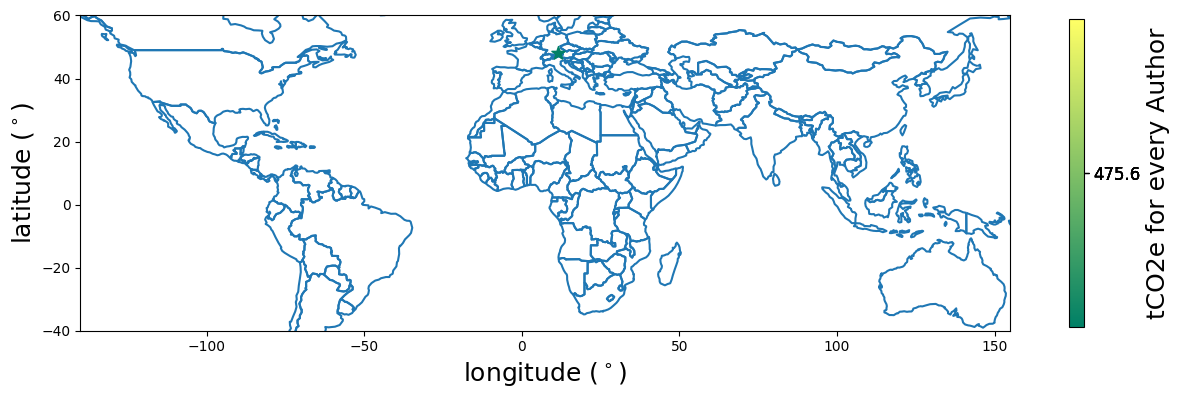

In [60]:
plot_sites(sites_to_plot[sites_to_plot['longitude']>10])
display(sites_to_plot[sites_to_plot['longitude']>10]['location'])

# what about three-hubs?

West Coast
                                      University  \
13  Lawrence Berkeley National Laboratory (LBNL)   
19          SLAC National Accelerator Laboratory   
28            University of California, Berkeley   

                                              Address  \
13     1 Cyclotron Road, Berkeley, CA 94720-8099, USA   
19  2575 Sand Hill Road, Menlo Park, CA 94205-7015...   
28  Department of Physics, 366 LeConte Hall MC 730...   

                                Universities_FullName       Short_Address  \
13  Lawrence Berkeley National Laboratory (LBNL), ...  CA 94720-8099, USA   
19  SLAC National Accelerator Laboratory, 2575 San...  CA 94205-7015, USA   
28  University of California, Berkeley, Department...  CA 94720-7300, USA   

                           Corrected_Name  \
13  Lawrence Berkeley National Laboratory   
19   SLAC National Accelerator Laboratory   
28     University of California, Berkeley   

                                      Start_Address  \
13    

/tmp/ipykernel_13328/3856592768.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key]=cumulative_distance
/tmp/ipykernel_13328/3856592768.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key]=cumulative_distance


                       University  \
17  Pennsylvania State University   
34         University of Maryland   
24    University at Albany (SUNY)   

                                              Address  \
17  Department of Physics, 104 Davey Lab, Universi...   
34  Department of Physics, College Park, MD 20742-...   
24  Department of Physics, 1400 Washington Avenue,...   

                                Universities_FullName       Short_Address  \
17  Pennsylvania State University, Department of P...  PA 16802-6300, USA   
34  University of Maryland, Department of Physics,...  MD 20742-4111, USA   
24  University at Albany (SUNY), Department of Phy...  NY 12222-1000, USA   

                   Corrected_Name  \
17  Pennsylvania State University   
34         University of Maryland   
24           University at Albany   

                                    Start_Address  \
17           Department of Physics, 104 Davey Lab   
34            Department of Physics, College Park   
24  D

/tmp/ipykernel_13328/3856592768.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key]=cumulative_distance


                              University  \
25       University College London (UCL)   
10               Imperial College London   
18  Royal Holloway, University of London   

                                              Address  \
25  Department of Physics and Astronomy, Gower Str...   
10  Physics Department, Blackett Laboratory, Londo...   
18         Department of Physics, Egham, TW20 0EX, UK   

                                Universities_FullName        Short_Address  \
25  University College London (UCL), Department of...  London WC1E 6BT, UK   
10  Imperial College London, Physics Department, B...   London SW7 2AZ, UK   
18  Royal Holloway, University of London, Departme...         TW20 0EX, UK   

                          Corrected_Name  \
25             University College London   
10               Imperial College London   
18  Royal Holloway, University of London   

                                        Start_Address  \
25  Department of Physics and Astronomy, Gower 

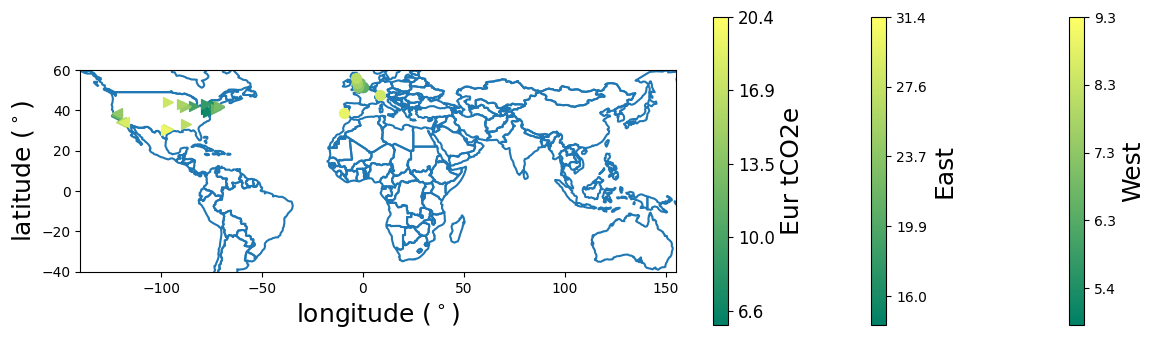

In [38]:
author_list.remove_filters()
author_list.filter_to_attendees()

key='cumulative_CO2e_100yr'
print("West Coast")
west_coast_cut=(author_list.author_university_locations['longitude']<-110)
west_author_dists=author_list.author_university_locations[west_coast_cut]
cross_calc(west_author_dists,flight_co2_100yr.calc_emissions_v2,key)
cross_calc(west_author_dists,flight_co2_30yr.calc_emissions_v2,key)

print(west_author_dists.sort_values(by=[key])[:3])

print('West Coast: ' ,scale*np.median(west_author_dists['cumulative_CO2e_100yr']),scale*np.median(west_author_dists['cumulative_CO2e_100yr'])*3/1.7)

print("East Coast")

east_coast_cut=(author_list.author_university_locations['longitude']>-100)&(author_list.author_university_locations['longitude']<-25)
east_author_dists=author_list.author_university_locations[east_coast_cut]
cross_calc(east_author_dists,flight_co2_100yr.calc_emissions_v2,key)
cross_calc(east_author_dists,flight_co2_30yr.calc_emissions_v2,key)

print(east_author_dists.sort_values(by=[key])[:3])
print('East Coast: ' ,scale*np.median(east_author_dists['cumulative_CO2e_100yr']),scale*np.median(east_author_dists['cumulative_CO2e_100yr'])*3/1.7)

print("Europe")
europe=(author_list.author_university_locations['longitude']>-25)&(author_list.author_university_locations['longitude']<110)
europe_author_dists=author_list.author_university_locations[europe]
cross_calc(europe_author_dists,flight_co2_100yr.calc_emissions_v2,key)
cross_calc(europe_author_dists,flight_co2_30yr.calc_emissions_v2,key)


print(europe_author_dists.sort_values(by=[key])[:3])
print('Europe: ' ,scale*np.median(europe_author_dists['cumulative_CO2e_100yr']),scale*np.median(europe_author_dists['cumulative_CO2e_100yr'])*3/1.7)




world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
carbon_map = matplotlib.colormaps['summer']
world.boundary.plot(ax=ax, zorder=1) 

markers=['<','>','o']
labels=['West','East','Eur']
for j,author_dists in enumerate([west_author_dists,east_author_dists,europe_author_dists]):
    longs=np.array(author_dists.sort_values(by=[key])['longitude'])
    lats=np.array(author_dists.sort_values(by=[key])['latitude'])
    for i,(long,lat) in enumerate(np.transpose([longs,lats])):
        color=carbon_map(i/len(longs))
        ax.scatter(long,lat, marker=markers[j], color=color,s=50)

    cmap = carbon_map
    min_dist=max(author_dists[key])
    max_dist=min(author_dists[key])
    norm = matplotlib.colors.Normalize(vmin=min_dist, vmax=max_dist)

    clb=plt.colorbar(matplotlib.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
                 label='tCO2e of flights',ticks=np.linspace(min_dist,max_dist,5,endpoint=True),
                format='%.1f')

    clb.set_label(f'{labels[j]}',fontsize=18)
    if j==2:
        clb.set_label(f'{labels[j]} tCO2e',fontsize=18)
plt.xlim([-140,155])
plt.ylim([-40,60])
plt.xlabel("longitude ($^\circ$)",fontsize=18)
plt.ylabel("latitude ($^\circ$)",fontsize=18)
clb.ax.tick_params(labelsize='large')

print('West Coast: ' ,scale*np.median(west_author_dists['cumulative_CO2e_100yr']),scale*np.median(west_author_dists['cumulative_CO2e_100yr'])*3/1.7)
print('East Coast: ' ,scale*np.median(east_author_dists['cumulative_CO2e_100yr']),scale*np.median(east_author_dists['cumulative_CO2e_100yr'])*3/1.7)
print('Europe: ' ,scale*np.median(europe_author_dists['cumulative_CO2e_100yr']),scale*np.median(europe_author_dists['cumulative_CO2e_100yr'])*3/1.7)

In [36]:
europe_author_dists

,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr
10,Imperial College London,"Physics Department, Blackett Laboratory, Londo...","Imperial College London, Physics Department, B...","London SW7 2AZ, UK",Imperial College London,"Physics Department, Blackett Laboratory","(Imperial College London, Exhibition Road, Bro...",-0.175641,51.498959,5,7.003851
12,Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra, ...",Laboratório de Instrumentação e Física Experim...,"Coimbra, Portugal",Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra",(LIP - Laboratório de Instrumentação e Física ...,-9.143368,38.739920,1,20.362393
18,"Royal Holloway, University of London","Department of Physics, Egham, TW20 0EX, UK","Royal Holloway, University of London, Departme...","TW20 0EX, UK","Royal Holloway, University of London","Department of Physics, Egham","(Royal Holloway, London Road, Englefield Green...",-0.564256,51.424450,2,7.671662
25,University College London (UCL),"Department of Physics and Astronomy, Gower Str...","University College London (UCL), Department of...","London WC1E 6BT, UK",University College London,"Department of Physics and Astronomy, Gower Street","(UCL Observatory, Watford Way, Grahame Park, M...",-0.242256,51.613334,7,6.568661
27,University of Bristol,"H.H. Wills Physics Laboratory, University of B...","University of Bristol, H.H. Wills Physics Labo...","BS8 1TL, United Kingdom",University of Bristol,"H.H. Wills Physics Laboratory, University of B...","(University of Bristol, Barrow Gurney, North S...",-2.630482,51.490558,1,8.584864
32,University of Edinburgh,"SUPA, School of Physics and Astronomy, Edinbur...","University of Edinburgh, SUPA, School of Physi...","EH9 3FD, UK",University of Edinburgh,"SUPA, School of Physics and Astronomy","(University of Edinburgh, Teviot Place, Quarte...",-3.188374,55.944076,1,11.167947
33,University of Liverpool,"Department of Physics, Liverpool L69 7ZE, UK","University of Liverpool, Department of Physics...","Liverpool L69 7ZE, UK",University of Liverpool,"Department of Physics, Liverpool L69 7ZE","(University of Liverpool, University Square, K...",-2.965834,53.407243,3,8.637194
37,University of Oxford,"Department of Physics, Denys Wilkinson Buildin...","University of Oxford, Department of Physics, D...","Oxford OX1 3RH, UK",University of Oxford,"Department of Physics, Denys Wilkinson Building","(Oxford University Museum of Natural History, ...",-1.255668,51.758708,2,7.798308
39,University of Sheffield,"Department of Physics and Astronomy, Sheffield...","University of Sheffield, Department of Physics...","Sheffield S3 7RH, UK",University of Sheffield,"Department of Physics and Astronomy, Sheffield...","(University of Sheffield, Western Bank, Broomf...",-1.483369,53.381504,3,8.272017
47,King's College London,"Department of Physics, King's College London, ...","King's College London, Department of Physics, ...","WC2R 2LS, United Kingdom",King's College London,"Department of Physics, King's College London","(Hodgkin Building, Tennis Street, Bermondsey V...",-0.090002,51.503085,1,7.842139


# Try better plotting

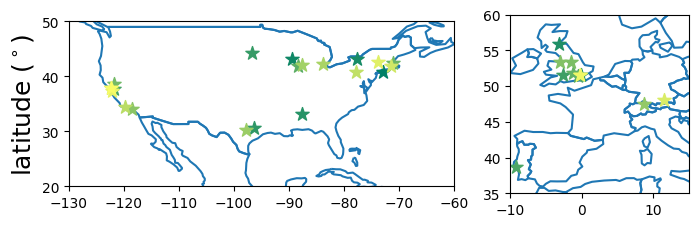

In [12]:
fig,axs=plt.subplots(1,2,figsize=(8,4),width_ratios=[70/25,1.3],height_ratios=[1])

longs=np.array(author_list.author_university_locations.sort_values(by=['author_count'])['longitude'])
lats=np.array(author_list.author_university_locations.sort_values(by=['author_count'])['latitude'])
author_count=np.array(author_list.author_university_locations['author_count'])

world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')


def plot_region(ax,xlims=[-140,155],ylims=[-40,60],labels=[True,True]):
    carbon_map = matplotlib.colormaps['summer']
    world.boundary.plot(ax=ax, zorder=1) 
    #lazy, plot them all not a sub-section, let limits cut them out 
    for i,(long,lat) in enumerate(np.transpose([longs,lats])):
        if long<xlims[0] or long>xlims[1]:
            continue
        if lat<ylims[0] or lat>ylims[1]:
            continue
        color=carbon_map(i/len(longs))
        ax.scatter(long,lat, marker='*', color=color,s=100)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    if labels[0]:
        ax.set_xlabel("longitude ($^\circ$)",fontsize=18)
    if labels[1]:
        ax.set_ylabel("latitude ($^\circ$)",fontsize=18)



    
plot_region(axs[0],xlims=[-130,-60],ylims=[20,50],labels=[False,True])
plot_region(axs[1],xlims=[-10,15],ylims=[35,60],labels=[False,False])
# plot_region(axs[2],xlims=[120,155],ylims=[-40,-15],labels=[False,False])

# cmap = carbon_map
# min_dist=max(author_count)
# max_dist=min(author_count)
# norm = matplotlib.colors.Normalize(vmin=min_dist, vmax=max_dist)
# clb=plt.colorbar(matplotlib.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
#              label='tCO2e of flights',ticks=np.linspace(min_dist,max_dist,5,endpoint=True),
#             format='%.1f')
# clb.set_label('Authors',fontsize=18)
# clb.ax.tick_params(labelsize='large')
# fig.tight_layout()

# code to start looking for nearest airports and do a API? 

In [13]:


airports = airportsdata.load('IATA')
airports_df = pd.DataFrame.from_dict(airports, orient='index')

def find_nearest_airports(lat, lon, top_n=3): # assume one of the top 3 is a 'proper airport'
    # Calculate distances and add them as a new column
    airports_df['distance'] = airports_df.apply(
        lambda row: great_circle((lat, lon), (row['lat'], row['lon'])).km,
        axis=1
    )
    
    # Sort the DataFrame by distance
    sorted_airports_df = airports_df.sort_values(by='distance')
    
    # Select the top N nearest airports
    nearest_airports = sorted_airports_df.head(top_n)
    
    return nearest_airports[['iata', 'distance']].values.tolist()

def get_nearest_airports(row):
    return find_nearest_airports(row['latitude'], row['longitude'])

author_aiports_df = grouped_by_country_or_state
author_aiports_df['Airports'] = author_aiports_df.apply(get_nearest_airports, axis=1)

In [14]:
author_aiports_df

,Binning1,author_count,University,longitude,latitude,Airports
0,Alabama,1,University of Alabama,-87.539673,33.212082,"[[TCL, 6.739840206642885], [AIV, 62.3161082287..."
1,California,29,Lawrence Berkeley National Laboratory (LBNL),-122.245630,37.876959,"[[OAK, 17.447245242661477], [CCR, 20.761000720..."
2,Deutschland,6,University of Maryland,11.582349,48.098982,"[[OBF, 22.312174397229704], [FEL, 26.227866715..."
3,Illinois,5,Fermi National Accelerator Laboratory (FNAL),-88.245782,41.842258,"[[DPA, 7.206869664300017], [AUZ, 20.5968147225..."
4,Massachusetts,2,University of Massachusetts,-71.096627,42.358253,"[[BOS, 7.432561088477726], [OWD, 19.6785139514..."
5,Michigan,4,University of Michigan,-83.710039,42.294214,"[[ARB, 8.452609719653305], [YIP, 20.2151503857..."
6,New York,8,Brookhaven National Laboratory (BNL),-72.886979,40.864795,"[[WSH, 5.054449425833201], [CTO, 8.29415613928..."
7,Pennsylvania,5,Pennsylvania State University,-77.855938,40.802583,"[[SCE, 11.809893669336985], [PSB, 21.485859597..."
8,Portugal,1,Laboratório de Instrumentação e Física Experim...,-9.143368,38.739920,"[[LIS, 4.646333055204788], [CAT, 18.4518162823..."
9,Rhode Island,5,Brown University,-71.408801,41.818640,"[[PVD, 10.823468532187361], [SFZ, 13.255879882..."


In [15]:


def check_direct_flights(airport_code1, airport_code2, api_key):
    url = f'http://api.aviationstack.com/v1/flights?access_key={api_key}&dep_iata={airport_code1}&arr_iata={airport_code2}'
    response = requests.get(url)
    data = response.json()
    # Check if any flights are found
    if 'data' in data and len(data['data']) > 0:
        return True
    return False

api_key = 'API-KEY'
airport_code1 = 'LHR'
airport_code2 = 'BOS'

has_direct_flights = check_direct_flights(airport_code1, airport_code2, api_key)
print(f"Direct flights from {airport_code1} to {airport_code2}: {'Yes' if has_direct_flights else 'No'}")

Direct flights from LHR to BOS: No


In [16]:
# maybe try 'https://opensky-network.org/api/states/all' instead?

# get attendance to brown university

In [17]:
attendance = pd.read_csv('../data/LZ_Brown_collab_24_attendence.csv', sep=',')
institute,counts=np.unique(attendance['Affiliation'],return_counts=True)

n_people_from=dict()
for i,k in enumerate(institute):
    n_people_from[str(k)]=int(counts[i])

In [18]:
institute

array(['BNL', 'Brown', 'Brown University', 'Imperial College',
       'Imperial College London', "King's College London (KCL)", 'LBL',
       'LBNL', 'LIP', 'LLNL',
       'Laboratório de Instrumentação e Física Experimental de Partículas (LIP)',
       'Lawrence Berkeley National Lab',
       'Lawrence Berkeley National Laboratory', 'Northwestern',
       'Northwestern University', 'Penn State University',
       'Pennsylvania State University', 'RHUL',
       'Royal Holloway University of London', 'SLAC',
       'SLAC National Accelerator Laboratory', 'SLAC/Stanford',
       'SUNY  Albany', 'South Dakota Mines', 'Stanford University',
       'Stanford/SLAC', 'U. Massachusetts', 'UAlbany', 'UAlbany SUNY',
       'UC Berkeley', 'UC Berkeley  LBL', 'UC Berkeley / LBNL',
       'UC Davis', 'UC San Diego', 'UC Santa Barbara', 'UCL', 'UCLA',
       'UCSB', 'UCSD', 'UMASS Amherst', 'University College London',
       'University at Albany', 'University at Albany  SUNY',
       'University o

In [19]:
key_author_to_respondent_inst={}


for author_inst in np.unique(author_dists['University']):
    key_author_to_respondent_inst[author_inst]=[]
    for 

SyntaxError: invalid syntax (1342265711.py, line 6)

In [ ]:
key_author_to_respondent_inst['Brookhaven National Laboratory (BNL)']=['BNL']
key_author_to_respondent_inst['Brown University']=['Brown', 'Brown University']
key_author_to_respondent_inst['Brown University']=['Brown', 'Brown University']